In [1]:
import gym
import gym_simple
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('PutBallInBoxEnvRandom5x5-v0')

print(env.action_space)
print(env.observation_space)

actions = ['up', 'down', 'left', 'right', 'up-right', 'up-left',
    'down-right', 'down-left', 'pick-up', 'put-down']

Discrete(10)
Box(5, 5, 5, 5, 5, 5, 3)


In [3]:
class QNetwork:
    def __init__(self, learning_rate, state_size, action_size, hidden_size, name='QNetwork'):
        with tf.variable_scope(name):
            # State inputs to the Q-network
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')

            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)

            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')

            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            
            # Linear hidden layer
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, hidden_size,
                                                         activation_fn=None)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc3, action_size,
                                                            activation_fn=None)

            # Minimize loss: (targetQ - Q)^2
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [4]:
# Environment specific parameters
action_size = env.action_space.n
state_size = len(env.observation_space.shape)

# Training parameters
train_episodes = 1000         # max number of episodes to learn from
max_steps = 1000              # max steps in an episode
gamma = 0.95                  # future reward discount

# Exploration parameters
explore_start = 1.0           # exploration probability at start
explore_stop = 0.1            # minimum exploration probability
decay_rate = 0.0001          # exponential decay rate for exploration prob

# Network parameters
hidden_size = 100             # number of units in each Q-network hidden layer
learning_rate = 0.0001        # Q-network learning rate

# Memory parameters
memory_size = 50000           # memory capacity
batch_size = 5000             # experience mini-batch size
pretrain_length = batch_size  # number experiences to pretrain the memory

# Update Target Network
c_steps = 100                  # every c steps

# Proportion of HER replay to standard replay
k = 4

In [10]:
from collections import deque

class Memory:
    def __init__(self, max_transitions=1000, max_goals=1000):
        self.buffer = deque(maxlen=max_transitions)
        self.goals = deque(maxlen=max_goals)

    def add_goal(self, goal_state):
        self.goals.append(goal_state)

    def sample_goals(self, n_goals):
        if len(self.goals) >= n_goals:
            idx = np.random.choice(np.arange(len(self.goals)),
                                   size=n_goals,
                                   replace=False)
            return [self.goals[ii] for ii in idx]
        else:
            return []

    # experience: (state, action, reward, next_state)
    def add_transition(self, experience):
        self.buffer.append(experience)

    def sample_transitions(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [11]:
# Initialize the simulation
state, reward, done, _ = env.reset()

memory = Memory(max_transitions=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    #env.render()
    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    goals_sample = memory.sample_goals(k)
    if done:
        # The simulation fails so no next state
        #next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add_transition((state, action, reward, next_state))
        for goal in goals_sample:
            if np.array_equal(next_state, goal):
                memory.add_transition((state,action,100,next_state))
            else:
                memory.add_transition((state,action,-1,next_state))
        # Start new episode
        state, reward, done, _ = env.reset()

    else:
        # Add experience to memory
        memory.add_transition((state, action, reward, next_state))
        for goal in goals_sample:
            if np.array_equal(next_state, goal):
                memory.add_transition((state,action,100,next_state))
            else:
                memory.add_transition((state,action,-1,next_state))
        state = next_state

goals_sample = memory.sample_goals(k)

tf.reset_default_graph()

mainQN = QNetwork(name='main', hidden_size=hidden_size, state_size=state_size, 
                  action_size=action_size, learning_rate=learning_rate)
targetQN = QNetwork(name='target', hidden_size=hidden_size, learning_rate=learning_rate,
                   action_size=action_size, state_size = state_size)

In [12]:
def updateTargetNetwork(tfVars):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign(var.value()))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [13]:
init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetNetwork(trainables)

cum_avg_reward_lst = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    step = 0
    total_reward = 0
    for ep in range(1, train_episodes):
        state, reward, done, _ = env.reset()
        print('Episode: ' + str(ep))
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render()

            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)

            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)

            total_reward += reward
            goals_sample = memory.sample_goals(k)
            if done:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                print("Reached the goal after {} timesteps".format(t))
                print('Episode: {}'.format(ep),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                # Add experience to memory
                memory.add_transition((state, action, reward, next_state))

                for goal in goals_sample:
                    #print(goal)
                    #print(next_state)
                    if np.array_equal(next_state, goal):
                        memory.add_transition((state,action,100,next_state))
                    else:
                        memory.add_transition((state,action,-1,next_state))
            else:
                # Add experience to memory
                # If is the last step in the episode and goal isnt Reached
                # return reward 100, since final state is emulating goal
                # if t+1 == max_steps:
                memory.add_transition((state, action, reward, next_state))
                for goal in goals_sample:
                    #print(goal)
                    #print(next_state)
                    if np.array_equal(next_state, goal):
                        memory.add_transition((state,action,100,next_state))
                    else:
                        memory.add_transition((state,action,-1,next_state))
                state = next_state
                t += 1

            # Sample mini-batch from memory
            batch = memory.sample_transitions(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])

            # Train network
            target_Qs = sess.run(targetQN.output, feed_dict={targetQN.inputs_: next_states})

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
            # After every C steps copy Q network to target network periodically
            # use target network to calculate target Qs
            if  t % c_steps == 0:
               updateTarget(targetOps,sess)

            if done: break
            elif t == max_steps:
                memory.add_goal(state)
        cum_avg_reward = total_reward/(ep)
        cum_avg_reward_lst.append(cum_avg_reward)
        print(cum_avg_reward)

    saver.save(sess, "checkpoints_her/putballinbox")


Episode: 1
-1000.0
Episode: 2
Reached the goal after 453 timesteps
Episode: 2 Training loss: 0.0521 Explore P: 0.8782
-676.5
Episode: 3
-784.3333333333334
Episode: 4
-838.25
Episode: 5
Reached the goal after 232 timesteps
Episode: 5 Training loss: 0.2405 Explore P: 0.7225
-697.0
Episode: 6
-747.5
Episode: 7
Reached the goal after 245 timesteps
Episode: 7 Training loss: 0.9798 Explore P: 0.6495
-661.4285714285714
Episode: 8
-703.75
Episode: 9
Reached the goal after 573 timesteps
Episode: 9 Training loss: 1.7661 Explore P: 0.5695
-678.1111111111111
Episode: 10
Reached the goal after 61 timesteps
Episode: 10 Training loss: 3.4501 Explore P: 0.5666
-606.4
Episode: 11
Reached the goal after 377 timesteps
Episode: 11 Training loss: 5.5398 Explore P: 0.5493
-576.4545454545455
Episode: 12
Reached the goal after 159 timesteps
Episode: 12 Training loss: 4.5276 Explore P: 0.5422
-533.3333333333334
Episode: 13
Reached the goal after 254 timesteps
Episode: 13 Training loss: 2.1325 Explore P: 0.5310

Reached the goal after 6 timesteps
Episode: 75 Training loss: 15.4401 Explore P: 0.2723
-126.14666666666666
Episode: 76
Reached the goal after 13 timesteps
Episode: 76 Training loss: 16.2095 Explore P: 0.2721
-123.34210526315789
Episode: 77
Reached the goal after 40 timesteps
Episode: 77 Training loss: 17.2489 Explore P: 0.2714
-120.96103896103897
Episode: 78
Reached the goal after 11 timesteps
Episode: 78 Training loss: 17.3459 Explore P: 0.2712
-118.26923076923077
Episode: 79
Reached the goal after 122 timesteps
Episode: 79 Training loss: 19.7215 Explore P: 0.2691
-117.0506329113924
Episode: 80
Reached the goal after 227 timesteps
Episode: 80 Training loss: 17.3677 Explore P: 0.2653
-117.175
Episode: 81
Reached the goal after 4 timesteps
Episode: 81 Training loss: 21.4566 Explore P: 0.2652
-114.54320987654322
Episode: 82
Reached the goal after 38 timesteps
Episode: 82 Training loss: 15.8512 Explore P: 0.2645
-112.39024390243902
Episode: 83
Reached the goal after 5 timesteps
Episode: 

Reached the goal after 7 timesteps
Episode: 143 Training loss: 25.7493 Explore P: 0.2306
-37.50349650349651
Episode: 144
Reached the goal after 38 timesteps
Episode: 144 Training loss: 32.2145 Explore P: 0.2301
-36.8125
Episode: 145
Reached the goal after 24 timesteps
Episode: 145 Training loss: 27.8022 Explore P: 0.2298
-36.03448275862069
Episode: 146
Reached the goal after 5 timesteps
Episode: 146 Training loss: 32.9518 Explore P: 0.2297
-35.136986301369866
Episode: 147
Reached the goal after 8 timesteps
Episode: 147 Training loss: 28.7637 Explore P: 0.2296
-34.27210884353742
Episode: 148
Reached the goal after 89 timesteps
Episode: 148 Training loss: 30.9712 Explore P: 0.2284
-33.96621621621622
Episode: 149
Reached the goal after 17 timesteps
Episode: 149 Training loss: 38.0990 Explore P: 0.2282
-33.18120805369127
Episode: 150
Reached the goal after 5 timesteps
Episode: 150 Training loss: 17.2922 Explore P: 0.2281
-32.32666666666667
Episode: 151
Reached the goal after 7 timesteps
Ep

Reached the goal after 27 timesteps
Episode: 211 Training loss: 56.3094 Explore P: 0.2147
0.9715639810426541
Episode: 212
Reached the goal after 471 timesteps
Episode: 212 Training loss: 50.9281 Explore P: 0.2094
-0.7830188679245284
Episode: 213
Reached the goal after 16 timesteps
Episode: 213 Training loss: 40.1308 Explore P: 0.2092
-0.38497652582159625
Episode: 214
Reached the goal after 6 timesteps
Episode: 214 Training loss: 47.7834 Explore P: 0.2091
0.056074766355140186
Episode: 215
Reached the goal after 3 timesteps
Episode: 215 Training loss: 43.1358 Explore P: 0.2091
0.5069767441860465
Episode: 216
Reached the goal after 116 timesteps
Episode: 216 Training loss: 62.0441 Explore P: 0.2078
0.4305555555555556
Episode: 217
Reached the goal after 4 timesteps
Episode: 217 Training loss: 42.9841 Explore P: 0.2078
0.8709677419354839
Episode: 218
Reached the goal after 16 timesteps
Episode: 218 Training loss: 43.3583 Explore P: 0.2076
1.2522935779816513
Episode: 219
Reached the goal aft

Reached the goal after 6 timesteps
Episode: 279 Training loss: 56.0723 Explore P: 0.1957
18.863799283154123
Episode: 280
Reached the goal after 9 timesteps
Episode: 280 Training loss: 54.6145 Explore P: 0.1956
19.12142857142857
Episode: 281
Reached the goal after 12 timesteps
Episode: 281 Training loss: 61.6400 Explore P: 0.1955
19.366548042704625
Episode: 282
Reached the goal after 11 timesteps
Episode: 282 Training loss: 68.8534 Explore P: 0.1954
19.613475177304963
Episode: 283
Reached the goal after 5 timesteps
Episode: 283 Training loss: 55.9532 Explore P: 0.1953
19.879858657243815
Episode: 284
Reached the goal after 19 timesteps
Episode: 284 Training loss: 60.0565 Explore P: 0.1951
20.095070422535212
Episode: 285
Reached the goal after 5 timesteps
Episode: 285 Training loss: 47.4895 Explore P: 0.1951
20.357894736842105
Episode: 286
Reached the goal after 22 timesteps
Episode: 286 Training loss: 52.2343 Explore P: 0.1948
20.55944055944056
Episode: 287
Reached the goal after 6 times

Reached the goal after 4 timesteps
Episode: 347 Training loss: 66.6437 Explore P: 0.1790
29.417867435158502
Episode: 348
Reached the goal after 59 timesteps
Episode: 348 Training loss: 65.5817 Explore P: 0.1785
29.451149425287355
Episode: 349
Reached the goal after 26 timesteps
Episode: 349 Training loss: 61.4224 Explore P: 0.1783
29.578796561604584
Episode: 350
Reached the goal after 10 timesteps
Episode: 350 Training loss: 68.7294 Explore P: 0.1782
29.751428571428573
Episode: 351
Reached the goal after 6 timesteps
Episode: 351 Training loss: 63.8039 Explore P: 0.1781
29.934472934472936
Episode: 352
Reached the goal after 12 timesteps
Episode: 352 Training loss: 75.8442 Explore P: 0.1780
30.099431818181817
Episode: 353
Reached the goal after 25 timesteps
Episode: 353 Training loss: 81.8934 Explore P: 0.1778
30.226628895184135
Episode: 354
Reached the goal after 13 timesteps
Episode: 354 Training loss: 68.9603 Explore P: 0.1777
30.387005649717516
Episode: 355
Reached the goal after 11 

Reached the goal after 7 timesteps
Episode: 416 Training loss: 88.4538 Explore P: 0.1710
38.74278846153846
Episode: 417
Reached the goal after 7 timesteps
Episode: 417 Training loss: 76.4645 Explore P: 0.1710
38.87290167865707
Episode: 418
Reached the goal after 13 timesteps
Episode: 418 Training loss: 74.0577 Explore P: 0.1709
38.98803827751196
Episode: 419
Reached the goal after 8 timesteps
Episode: 419 Training loss: 60.2042 Explore P: 0.1708
39.114558472553696
Episode: 420
Reached the goal after 4 timesteps
Episode: 420 Training loss: 74.2024 Explore P: 0.1708
39.25
Episode: 421
Reached the goal after 12 timesteps
Episode: 421 Training loss: 89.2059 Explore P: 0.1707
39.365795724465556
Episode: 422
Reached the goal after 10 timesteps
Episode: 422 Training loss: 83.7504 Explore P: 0.1706
39.485781990521325
Episode: 423
Reached the goal after 3 timesteps
Episode: 423 Training loss: 88.7092 Explore P: 0.1706
39.621749408983455
Episode: 424
Reached the goal after 7 timesteps
Episode: 4

Reached the goal after 9 timesteps
Episode: 485 Training loss: 97.0190 Explore P: 0.1641
45.48041237113402
Episode: 486
Reached the goal after 11 timesteps
Episode: 486 Training loss: 85.9185 Explore P: 0.1640
45.56995884773662
Episode: 487
Reached the goal after 7 timesteps
Episode: 487 Training loss: 85.2374 Explore P: 0.1640
45.667351129363446
Episode: 488
Reached the goal after 7 timesteps
Episode: 488 Training loss: 98.4555 Explore P: 0.1639
45.76434426229508
Episode: 489
Reached the goal after 82 timesteps
Episode: 489 Training loss: 99.0726 Explore P: 0.1634
45.70756646216769
Episode: 490
Reached the goal after 8 timesteps
Episode: 490 Training loss: 85.0044 Explore P: 0.1633
45.80204081632653
Episode: 491
Reached the goal after 7 timesteps
Episode: 491 Training loss: 90.2291 Explore P: 0.1633
45.89816700610998
Episode: 492
Reached the goal after 9 timesteps
Episode: 492 Training loss: 77.2221 Explore P: 0.1632
45.989837398373986
Episode: 493
Reached the goal after 5 timesteps
E

Reached the goal after 3 timesteps
Episode: 554 Training loss: 92.1382 Explore P: 0.1580
50.604693140794225
Episode: 555
Reached the goal after 4 timesteps
Episode: 555 Training loss: 104.1448 Explore P: 0.1580
50.68648648648649
Episode: 556
Reached the goal after 4 timesteps
Episode: 556 Training loss: 80.3405 Explore P: 0.1580
50.76798561151079
Episode: 557
Reached the goal after 10 timesteps
Episode: 557 Training loss: 102.6777 Explore P: 0.1579
50.83842010771993
Episode: 558
Reached the goal after 20 timesteps
Episode: 558 Training loss: 88.5639 Explore P: 0.1578
50.89068100358423
Episode: 559
Reached the goal after 9 timesteps
Episode: 559 Training loss: 92.2594 Explore P: 0.1577
50.96243291592129
Episode: 560
Reached the goal after 4 timesteps
Episode: 560 Training loss: 93.3431 Explore P: 0.1577
51.042857142857144
Episode: 561
Reached the goal after 10 timesteps
Episode: 561 Training loss: 93.6001 Explore P: 0.1576
51.11229946524064
Episode: 562
Reached the goal after 12 timeste

Reached the goal after 4 timesteps
Episode: 622 Training loss: 95.7440 Explore P: 0.1521
54.37620578778135
Episode: 623
Reached the goal after 15 timesteps
Episode: 623 Training loss: 99.4311 Explore P: 0.1520
54.42536115569823
Episode: 624
Reached the goal after 5 timesteps
Episode: 624 Training loss: 111.3986 Explore P: 0.1520
54.49038461538461
Episode: 625
Reached the goal after 4 timesteps
Episode: 625 Training loss: 126.2370 Explore P: 0.1519
54.5568
Episode: 626
Reached the goal after 7 timesteps
Episode: 626 Training loss: 110.6643 Explore P: 0.1519
54.61821086261981
Episode: 627
Reached the goal after 119 timesteps
Episode: 627 Training loss: 95.7396 Explore P: 0.1513
54.50079744816587
Episode: 628
Reached the goal after 49 timesteps
Episode: 628 Training loss: 121.2543 Explore P: 0.1510
54.495222929936304
Episode: 629
Reached the goal after 6 timesteps
Episode: 629 Training loss: 116.4345 Explore P: 0.1510
54.55802861685215
Episode: 630
Reached the goal after 8 timesteps
Episo

Reached the goal after 36 timesteps
Episode: 690 Training loss: 101.0555 Explore P: 0.1448
56.78695652173913
Episode: 691
Reached the goal after 4 timesteps
Episode: 691 Training loss: 96.6492 Explore P: 0.1448
56.84370477568741
Episode: 692
Reached the goal after 7 timesteps
Episode: 692 Training loss: 84.9909 Explore P: 0.1447
56.895953757225435
Episode: 693
Reached the goal after 7 timesteps
Episode: 693 Training loss: 98.4096 Explore P: 0.1447
56.94805194805195
Episode: 694
Reached the goal after 7 timesteps
Episode: 694 Training loss: 102.1550 Explore P: 0.1447
57.0
Episode: 695
Reached the goal after 131 timesteps
Episode: 695 Training loss: 94.4374 Explore P: 0.1441
56.87338129496403
Episode: 696
Reached the goal after 8 timesteps
Episode: 696 Training loss: 104.8891 Explore P: 0.1440
56.923850574712645
Episode: 697
Reached the goal after 9 timesteps
Episode: 697 Training loss: 96.8140 Explore P: 0.1440
56.972740315638454
Episode: 698
Reached the goal after 12 timesteps
Episode:

Reached the goal after 5 timesteps
Episode: 759 Training loss: 107.3459 Explore P: 0.1307
55.70882740447958
Episode: 760
Reached the goal after 8 timesteps
Episode: 760 Training loss: 112.5361 Explore P: 0.1307
55.75657894736842
Episode: 761
Reached the goal after 55 timesteps
Episode: 761 Training loss: 102.1176 Explore P: 0.1305
55.74244415243101
Episode: 762
Reached the goal after 6 timesteps
Episode: 762 Training loss: 80.3557 Explore P: 0.1305
55.79265091863517
Episode: 763
Reached the goal after 4 timesteps
Episode: 763 Training loss: 106.6132 Explore P: 0.1305
55.84534731323722
Episode: 764
Reached the goal after 23 timesteps
Episode: 764 Training loss: 93.0223 Explore P: 0.1304
55.87303664921466
Episode: 765
Reached the goal after 116 timesteps
Episode: 765 Training loss: 103.4446 Explore P: 0.1301
55.77908496732026
Episode: 766
Reached the goal after 7 timesteps
Episode: 766 Training loss: 99.1844 Explore P: 0.1300
55.82767624020888
Episode: 767
Reached the goal after 24 times

Reached the goal after 11 timesteps
Episode: 827 Training loss: 85.0845 Explore P: 0.1251
56.9782345828295
Episode: 828
Reached the goal after 10 timesteps
Episode: 828 Training loss: 94.2785 Explore P: 0.1251
57.018115942028984
Episode: 829
Reached the goal after 6 timesteps
Episode: 829 Training loss: 87.5712 Explore P: 0.1250
57.0627261761158
Episode: 830
Reached the goal after 21 timesteps
Episode: 830 Training loss: 90.3662 Explore P: 0.1250
57.089156626506025
Episode: 831
Reached the goal after 6 timesteps
Episode: 831 Training loss: 88.2912 Explore P: 0.1250
57.13357400722022
Episode: 832
Reached the goal after 8 timesteps
Episode: 832 Training loss: 92.5628 Explore P: 0.1249
57.17548076923077
Episode: 833
Reached the goal after 10 timesteps
Episode: 833 Training loss: 84.9365 Explore P: 0.1249
57.21488595438175
Episode: 834
Reached the goal after 4 timesteps
Episode: 834 Training loss: 74.0004 Explore P: 0.1249
57.26139088729017
Episode: 835
Reached the goal after 6 timesteps
E

Reached the goal after 5 timesteps
Episode: 895 Training loss: 97.4808 Explore P: 0.1228
59.27821229050279
Episode: 896
Reached the goal after 10 timesteps
Episode: 896 Training loss: 96.1537 Explore P: 0.1228
59.3125
Episode: 897
Reached the goal after 9 timesteps
Episode: 897 Training loss: 108.3931 Explore P: 0.1228
59.34782608695652
Episode: 898
Reached the goal after 6 timesteps
Episode: 898 Training loss: 91.9680 Explore P: 0.1228
59.38641425389755
Episode: 899
Reached the goal after 7 timesteps
Episode: 899 Training loss: 91.6152 Explore P: 0.1228
59.4238042269188
Episode: 900
Reached the goal after 9 timesteps
Episode: 900 Training loss: 104.2042 Explore P: 0.1227
59.458888888888886
Episode: 901
Reached the goal after 8 timesteps
Episode: 901 Training loss: 87.5249 Explore P: 0.1227
59.49500554938957
Episode: 902
Reached the goal after 5 timesteps
Episode: 902 Training loss: 98.2428 Explore P: 0.1227
59.534368070953434
Episode: 903
Reached the goal after 4 timesteps
Episode: 90

Reached the goal after 11 timesteps
Episode: 963 Training loss: 69.0565 Explore P: 0.1196
60.65628245067497
Episode: 964
Reached the goal after 7 timesteps
Episode: 964 Training loss: 69.5074 Explore P: 0.1196
60.689834024896264
Episode: 965
Reached the goal after 8 timesteps
Episode: 965 Training loss: 80.6988 Explore P: 0.1196
60.722279792746114
Episode: 966
Reached the goal after 88 timesteps
Episode: 966 Training loss: 91.1041 Explore P: 0.1194
60.67184265010352
Episode: 967
Reached the goal after 8 timesteps
Episode: 967 Training loss: 82.4809 Explore P: 0.1194
60.70423991726991
Episode: 968
Reached the goal after 27 timesteps
Episode: 968 Training loss: 88.9791 Explore P: 0.1194
60.71694214876033
Episode: 969
Reached the goal after 7 timesteps
Episode: 969 Training loss: 82.1577 Explore P: 0.1194
60.75025799793602
Episode: 970
Reached the goal after 5 timesteps
Episode: 970 Training loss: 72.3213 Explore P: 0.1193
60.78556701030928
Episode: 971
Reached the goal after 144 timestep

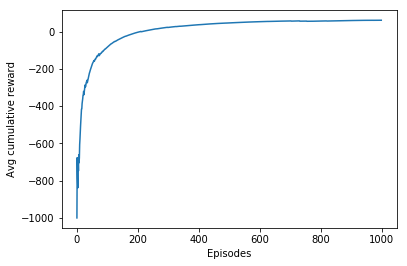

In [14]:
plt.plot(cum_avg_reward_lst)
plt.ylabel('Avg cumulative reward')
plt.xlabel('Episodes')
plt.show()

In [15]:
# Test the trained DQN + HER model
import time
import copy

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Load meta graph and restore weights
    saver = tf.train.import_meta_graph('checkpoints_her/putballinbox.meta')
    saver.restore(sess,tf.train.latest_checkpoint('checkpoints_her/'))

    graph = tf.get_default_graph()
    inputs_tensor = graph.get_tensor_by_name("main/inputs:0")
    output_tensor = graph.get_tensor_by_name("main/fully_connected_3/BiasAdd:0")


    target_output_tensor = tf.contrib.copy_graph.get_copied_op(output_tensor, graph)

    total_reward = 0
    n_episodes = 10
    n_steps = 20

    for i_episode in range(n_episodes):
        print('Episode: ' + str(i_episode+1))
        state,_,_,_ = env.reset()
        for t in range(n_steps):
            env.render()
            feed = {inputs_tensor: state.reshape((1, *state.shape))}
            Qs = sess.run(target_output_tensor, feed_dict=feed)
            action = np.argmax(Qs)
            next_state, r, done, _ = env.step(action)
            state = next_state
            total_reward += r
            if done:
                print("Reached the goal after {} timesteps".format(t+1))
                break
            time.sleep(0.5)
        if not done:
            print("Didnt reach the goal after {} timesteps".format(n_steps))
        print(total_reward/(i_episode + 1))
    env.close()

INFO:tensorflow:Restoring parameters from checkpoints_her/putballinbox
Episode: 1
Reached the goal after 10 timesteps
91.0
Episode: 2
Reached the goal after 7 timesteps
92.5
Episode: 3
Reached the goal after 10 timesteps
92.0
Episode: 4
Didnt reach the goal after 20 timesteps
64.0
Episode: 5
Reached the goal after 6 timesteps
70.2
Episode: 6
Reached the goal after 4 timesteps
74.66666666666667
Episode: 7
Didnt reach the goal after 20 timesteps
61.142857142857146
Episode: 8
Reached the goal after 6 timesteps
65.375
Episode: 9
Didnt reach the goal after 20 timesteps
55.888888888888886
Episode: 10
Reached the goal after 8 timesteps
59.6
